In [340]:
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

In [341]:
files = glob.glob('.\\data\\ha_temp_*.png')

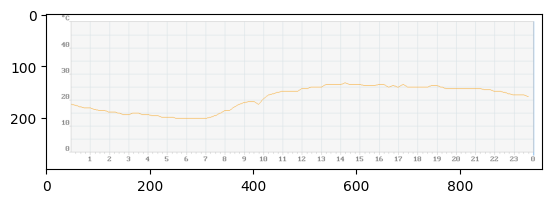

(300, 960, 4)


In [342]:
img = mpimg.imread(files[5])

plt.imshow(img)
plt.show()

print(img.shape) 

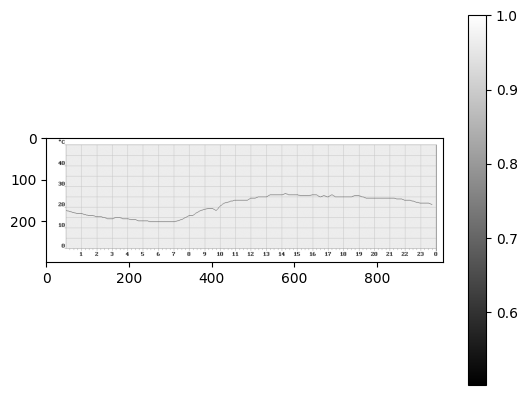

(300, 960)


In [ ]:
# grayscale image
gray = img[..., :3].mean(axis=2)

plt.imshow(gray, cmap='gray')
plt.colorbar()
plt.show()

print(gray.shape) 

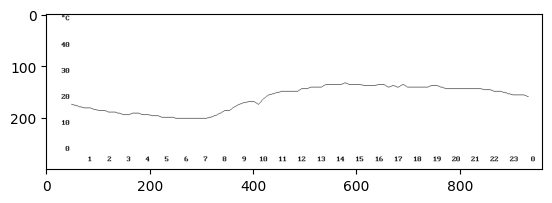

In [ ]:
# Threshold: find dark pixels (line)
line_mask = (gray > 0.6) * 1

plt.imshow(line_mask, cmap='gray')
plt.show()

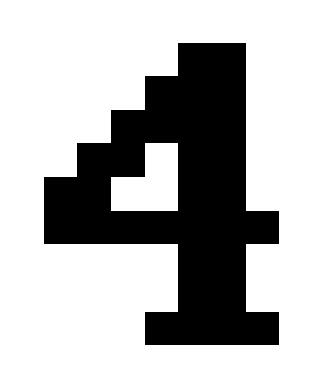

np.int64(40)

In [ ]:
# determine y-axis scale by checking the tick labels
# 20 and 40 degrees Celsius are used as reference points

tick_label_20 = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 0, 0, 0, 0, 1, 1],
    [1, 0, 0, 1, 1, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 1, 1],
    [1, 1, 1, 1, 0, 0, 1, 1, 1],
    [1, 1, 1, 0, 0, 1, 1, 1, 1],
    [1, 1, 0, 0, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 1, 1, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1] ])

tick_label_40 = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 0, 1, 1],
    [1, 1, 1, 1, 0, 0, 0, 1, 1],
    [1, 1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 0, 0, 1, 0, 0, 1, 1],
    [1, 0, 0, 1, 1, 0, 0, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 0, 0, 1, 1],
    [1, 1, 1, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1] ])

tick_label = line_mask[55:66, 29:38]

plt.imshow(tick_label, cmap='gray')
plt.axis('off')
plt.show()

axis_scale = (
      (np.max(tick_label - tick_label_20) == 0) * 20 
    + (np.max(tick_label - tick_label_40) == 0) * 40 )

axis_scale

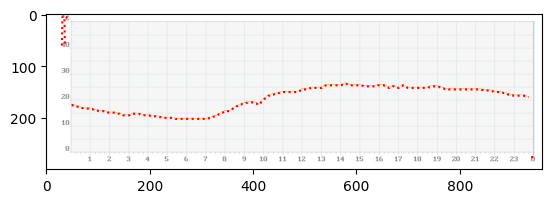

In [ ]:
# Extract the y-pixel number of the line

line_y = []
for x in range(line_mask.shape[1]):
    y_indices = np.where(line_mask[:, x] == 0)[0]
    if len(y_indices) > 0:
        line_y.append(y_indices[0])  # take the first (topmost) pixel
    else:
        line_y.append(np.nan)  # no line found at this x

plt.imshow(img)
plt.plot(range(len(line_y)), line_y, 'r:')
plt.show()

(0.0, 40.0)

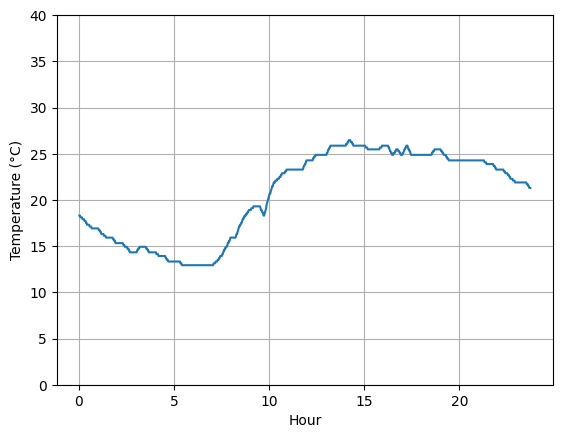

In [ ]:
# convert pixels to values

data = np.array(line_y)[49:-26]

# x-pixel  48 corresponds to hour 0
# x-pixel -16 corresponds to hour 24
min_max_hour = 24 * (np.array([49, 960-26]) - 48) / (960-16 - 48)
hour = np.linspace(min_max_hour[0], min_max_hour[1], len(data))

# y-pixel 267 corresponds to temperature 0
# y-pixel  66 corresponds to temperature axis_scale
temperature = axis_scale * (data - 267) / (66 - 267)

plt.plot(hour, temperature)
plt.xlabel('Hour')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.ylim(0, 40)